In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/RECORDS
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/subject_info.csv
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/LICENSE.txt
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/Seizures-list-PN05.txt
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/PN05-2.edf
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/PN05-4.edf
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/PN05-3.edf
/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN00/PN00-1.edf
/kaggle/input/epilepsy-seizure-datase

In [2]:
pip install pyedflib

Note: you may need to restart the kernel to use updated packages.


Random Forest

In [3]:
# import os
# import re
# import numpy as np
# import pyedflib
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score

# # ========== 1. Time Converter ==========
# def time_to_sec(t_str):
#     t_str = t_str.strip().replace(":", ".")
#     h, m, s = map(int, t_str.split("."))
#     return h * 3600 + m * 60 + s

# # ========== 2. Universal Summary Parser ==========
# def parse_summary(file_path):
#     with open(file_path, "r") as f:
#         content = f.read()

#     patient_id = os.path.basename(file_path).split("-")[2].split(".")[0]  # e.g., "PN01"
#     seizure_data = []

#     # Match all blocks with file name
#     file_blocks = re.findall(r"Seizure n[\w ]*:?[\s\S]*?File name:\s*(\S+\.edf)[\s\S]*?Registration start time:\s*(\d+.\d+.\d+)[\s\S]*?Registration end time:\s*(\d+.\d+.\d+)[\s\S]*?Seizure start time:\s*(\d+.\d+.\d+)[\s\S]*?Seizure end time:\s*(\d+.\d+.\d+)", content)
    
#     # Match special PN01-style (1 file with multiple seizures, times under 'Seizure n' without file name)
#     single_file_match = re.search(r"File name:\s*(PN\d+\.edf)", content)
#     if single_file_match:
#         edf_file = single_file_match.group(1)
#         start_time = re.search(r"Registration start time:\s*(\d+\.\d+\.\d+)", content).group(1)
#         end_time = re.search(r"Registration end time:\s*(\d+\.\d+\.\d+)", content).group(1)
#         seizure_only_blocks = re.findall(r"Seizure n \d+\s+Start time:\s*(\d+[:.]\d+[:.]\d+)\s+End time:\s*(\d+[:.]\d+[:.]\d+)", content)
#         for s_start, s_end in seizure_only_blocks:
#             seizure_data.append({
#                 "edf_file": edf_file,
#                 "recording_start": time_to_sec(start_time),
#                 "recording_end": time_to_sec(end_time),
#                 "seizure_start": time_to_sec(s_start),
#                 "seizure_end": time_to_sec(s_end),
#                 "preseizure_start": max(time_to_sec(s_start) - 900, 0)
#             })

#     for file, start, end, sz_start, sz_end in file_blocks:
#         seizure_data.append({
#             "edf_file": file,
#             "recording_start": time_to_sec(start),
#             "recording_end": time_to_sec(end),
#             "seizure_start": time_to_sec(sz_start),
#             "seizure_end": time_to_sec(sz_end),
#             "preseizure_start": max(time_to_sec(sz_start) - 900, 0)
#         })

#     return seizure_data

# # ========== 3. EDF Channel Extractor ==========
# def extract_channels(file_path, channels=[0, 1, 2, 3]):
#     f = pyedflib.EdfReader(file_path)
#     n_samples = f.getNSamples()[0]
#     data = np.zeros((len(channels), n_samples))
#     for i, ch in enumerate(channels):
#         data[i, :] = f.readSignal(ch)
#     f._close()
#     return data

# # ========== 4. Feature Extractor ==========
# def extract_features(signal):
#     feats = []
#     for ch in signal:
#         feats.extend([
#             np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
#             np.percentile(ch, 25), np.percentile(ch, 75)
#         ])
#     return feats

# # ========== 5. Segment and Label ==========
# def segment_and_extract(data, info, fs=512, window_sec=10):
#     window_size = fs * window_sec
#     total_windows = data.shape[1] // window_size
#     X, y = [], []

#     for i in range(total_windows):
#         start = i * window_size
#         end = start + window_size
#         global_time = info["recording_start"] + start // fs

#         if info["seizure_start"] <= global_time < info["seizure_end"]:
#             label = 2
#         elif info["preseizure_start"] <= global_time < info["seizure_start"]:
#             label = 1
#         else:
#             label = 0

#         segment = data[:, start:end]
#         X.append(extract_features(segment))
#         y.append(label)

#     return np.array(X), np.array(y)

# # ========== 6. Dataset Builder ==========
# def build_dataset(summary_data, edf_folder):
#     X_all, y_all = [], []
#     for info in summary_data:
#         path = os.path.join(edf_folder, info["edf_file"])
#         if not os.path.exists(path):
#             print(f"⚠️ Missing EDF: {path}")
#             continue
#         try:
#             data = extract_channels(path)
#             X, y = segment_and_extract(data, info)
#             X_all.append(X)
#             y_all.append(y)
#         except Exception as e:
#             print(f"❌ Error with {info['edf_file']}: {e}")
#     if not X_all:
#         return None, None
#     return np.concatenate(X_all), np.concatenate(y_all)

# # ========== 7. Train and Evaluate ==========
# def train_random_forest(X, y):
#     X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

#     clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
#     clf.fit(X_train, y_train)

#     print("\n✅ Validation Results")
#     print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

#     print("\n✅ Test Results")
#     print(classification_report(y_test, clf.predict(X_test), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

# # ========== 8. Main Loop ==========
# if __name__ == "__main__":
#     base_folder = "/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0"  # <- change to your path containing PN folders
#     X_all, y_all = [], []

#     for subdir in os.listdir(base_folder):
#         subpath = os.path.join(base_folder, subdir)
#         if not os.path.isdir(subpath): continue

#         summary_files = [f for f in os.listdir(subpath) if f.startswith("Seizures-list") and f.endswith(".txt")]
#         if not summary_files:
#             print(f"⚠️ No summary in {subpath}")
#             continue

#         summary_path = os.path.join(subpath, summary_files[0])
#         print(f"\n📁 Processing: {summary_path}")
#         try:
#             summary_data = parse_summary(summary_path)
#             X, y = build_dataset(summary_data, subpath)
#             if X is not None:
#                 X_all.append(X)
#                 y_all.append(y)
#         except Exception as e:
#             print(f"❌ Failed on {summary_path}: {e}")

#     if X_all:
#         X_all = np.concatenate(X_all)
#         y_all = np.concatenate(y_all)
#         print(f"\n✅ Final Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features each")
#         train_random_forest(X_all, y_all)
#     else:
#         print("❌ No valid data found.")


In [4]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


Random forest with SMOTE


In [9]:
import os
import re
import numpy as np
import pyedflib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

def time_to_sec(t_str):
    t_str = t_str.strip().replace(":", ".")
    h, m, s = map(int, t_str.split("."))
    return h * 3600 + m * 60 + s

def parse_summary(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    seizure_data = []

    file_blocks = re.findall(r"Seizure n[\w ]*:?[\s\S]*?File name:\s*(\S+\.edf)[\s\S]*?Registration start time:\s*(\d+.\d+.\d+)[\s\S]*?Registration end time:\s*(\d+.\d+.\d+)[\s\S]*?Seizure start time:\s*(\d+.\d+.\d+)[\s\S]*?Seizure end time:\s*(\d+.\d+.\d+)", content)
    
    single_file_match = re.search(r"File name:\s*(PN\d+\.edf)", content)
    if single_file_match:
        edf_file = single_file_match.group(1)
        try:
            start_time = re.search(r"Registration start time:\s*(\d+\.\d+\.\d+)", content).group(1)
            end_time = re.search(r"Registration end time:\s*(\d+\.\d+\.\d+)", content).group(1)
            seizure_only_blocks = re.findall(r"Seizure n \d+\s+Start time:\s*(\d+[:.]\d+[:.]\d+)\s+End time:\s*(\d+[:.]\d+[:.]\d+)", content)
            for s_start, s_end in seizure_only_blocks:
                seizure_data.append({
                    "edf_file": edf_file,
                    "recording_start": time_to_sec(start_time),
                    "recording_end": time_to_sec(end_time),
                    "seizure_start": time_to_sec(s_start),
                    "seizure_end": time_to_sec(s_end),
                    "preseizure_start": max(time_to_sec(s_start) - 900, 0)
                })
        except:
            pass

    for file, start, end, sz_start, sz_end in file_blocks:
        seizure_data.append({
            "edf_file": file,
            "recording_start": time_to_sec(start),
            "recording_end": time_to_sec(end),
            "seizure_start": time_to_sec(sz_start),
            "seizure_end": time_to_sec(sz_end),
            "preseizure_start": max(time_to_sec(sz_start) - 900, 0)
        })

    return seizure_data

def extract_channels(file_path, channels=[0, 1, 2, 3]):
    f = pyedflib.EdfReader(file_path)
    n_samples = f.getNSamples()[0]
    data = np.zeros((len(channels), n_samples))
    for i, ch in enumerate(channels):
        data[i, :] = f.readSignal(ch)
    f._close()
    return data

def extract_features(signal):
    feats = []
    for ch in signal:
        feats.extend([
            np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
            np.percentile(ch, 25), np.percentile(ch, 75)
        ])
    return feats

def segment_and_extract(data, info, fs=512, window_sec=10):
    window_size = fs * window_sec
    total_windows = data.shape[1] // window_size
    X, y = [], []

    for i in range(total_windows):
        start = i * window_size
        end = start + window_size
        global_time = info["recording_start"] + start // fs

        if info["seizure_start"] <= global_time < info["seizure_end"]:
            label = 2
        elif info["preseizure_start"] <= global_time < info["seizure_start"]:
            label = 1
        else:
            label = 0

        segment = data[:, start:end]
        X.append(extract_features(segment))
        y.append(label)

    return np.array(X), np.array(y)

def build_dataset(summary_data, edf_folder):
    X_all, y_all = [], []
    for info in summary_data:
        edf_path = os.path.join(edf_folder, info["edf_file"])
        if not os.path.exists(edf_path):
            print(f"⚠️ Missing EDF: {edf_path}")
            continue
        try:
            data = extract_channels(edf_path)
            X, y = segment_and_extract(data, info)
            X_all.append(X)
            y_all.append(y)
        except Exception as e:
            print(f"❌ Error in {info['edf_file']}: {e}")
    if not X_all:
        return None, None
    return np.concatenate(X_all), np.concatenate(y_all)

# def train_random_forest(X, y):
#     print("\n📊 Original label distribution:", np.bincount(y))

#     smote = SMOTE(random_state=42)
#     X_res, y_res = smote.fit_resample(X, y)
#     print("✅ After SMOTE label distribution:", np.bincount(y_res))

#     X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

#     clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
#     clf.fit(X_train, y_train)

#     print("\n✅ Validation Report")
#     print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

#     print("\n✅ Test Report")
#     print(classification_report(y_test, clf.predict(X_test), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

import joblib  # ← Add this at the top of your script

def train_random_forest(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Test Report")
    print(classification_report(y_test, clf.predict(X_test), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    # ✅ Save model to file
    joblib.dump(clf, "random_forest_model.pkl")
    print("💾 Model saved as random_forest_model.pkl")


In [10]:

if __name__ == "__main__":
    base_folder = "/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0"
    X_all, y_all = [], []

    for subdir in os.listdir(base_folder):
        subpath = os.path.join(base_folder, subdir)
        if not os.path.isdir(subpath):
            continue

        summary_files = [f for f in os.listdir(subpath) if f.startswith("Seizures-list") and f.endswith(".txt")]
        if not summary_files:
            continue

        summary_path = os.path.join(subpath, summary_files[0])
        print(f"\n📁 Processing: {summary_path}")
        try:
            summary_data = parse_summary(summary_path)
            X, y = build_dataset(summary_data, subpath)
            if X is not None:
                X_all.append(X)
                y_all.append(y)
        except Exception as e:
            print(f"❌ Failed on {summary_path}: {e}")

    if X_all:
        X_all = np.concatenate(X_all)
        y_all = np.concatenate(y_all)
        print(f"\n✅ Final Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features")
        train_random_forest(X_all, y_all)
    else:
        print("❌ No valid data found.")



📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/Seizures-list-PN05.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN00/Seizures-list-PN00.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN17/Seizures-list-PN17.txt
❌ Error in PN17-2.edf: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN17/PN17-2.edf: file has already been opened

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/Seizures-list-PN11.txt
⚠️ Missing EDF: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/PN11-.edf

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN14/Seizures-list-PN14.txt

📁 Processing: /kaggle/input/epilepsy-seizure-da

<!-- XGB -->

In [ ]:
# import joblib

# # After fitting the model
# clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# clf.fit(X_train, y_train)

# # Save the model
# joblib.dump(clf, "random_forest_model.pkl")


In [7]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib  # 🔑 Add this line

def train_xgboost(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    clf = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )

    clf.fit(X_train, y_train)

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Test Report")
    print(classification_report(y_test, clf.predict(X_test), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    # ✅ Save the trained model
    joblib.dump(clf, "xgboost_model.pkl")
    print("💾 Model saved as xgboost_model.pkl")


In [12]:
if __name__ == "__main__":
    base_folder = "/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0"
    X_all, y_all = [], []

    for subdir in os.listdir(base_folder):
        subpath = os.path.join(base_folder, subdir)
        if not os.path.isdir(subpath):
            continue

        summary_files = [f for f in os.listdir(subpath) if f.startswith("Seizures-list") and f.endswith(".txt")]
        if not summary_files:
            continue

        summary_path = os.path.join(subpath, summary_files[0])
        print(f"\n📁 Processing: {summary_path}")
        try:
            summary_data = parse_summary(summary_path)
            X, y = build_dataset(summary_data, subpath)
            if X is not None:
                X_all.append(X)
                y_all.append(y)
        except Exception as e:
            print(f"❌ Failed on {summary_path}: {e}")

    if X_all:
        X_all = np.concatenate(X_all)
        y_all = np.concatenate(y_all)
        print(f"\n✅ Final Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features")
        train_xgboost(X_all, y_all)
    else:
        print("❌ No valid data found.")



📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/Seizures-list-PN05.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN00/Seizures-list-PN00.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN17/Seizures-list-PN17.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/Seizures-list-PN11.txt
⚠️ Missing EDF: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/PN11-.edf

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN14/Seizures-list-PN14.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN07/Seizures-list-PN07.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete

Seizure Net

In [4]:
# # NEW: No feature extraction
# def segment_and_extract(data, info, fs=512, window_sec=10):
#     window_size = fs * window_sec
#     total_windows = data.shape[1] // window_size
#     X = []
#     y = []

#     for i in range(total_windows):
#         start = i * window_size
#         end = start + window_size
#         global_time = info["recording_start"] + start // fs

#         if info["seizure_start"] <= global_time < info["seizure_end"]:
#             label = 2
#         elif info["preseizure_start"] <= global_time < info["seizure_start"]:
#             label = 1
#         else:
#             label = 0

#         segment = data[:, start:end]  # shape: [4, 5120]
#         X.append(segment)
#         y.append(label)

#     return np.array(X), np.array(y)


In [5]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# def build_seizurenet(input_shape=(4, 5120, 1), num_classes=3):
#     model = Sequential()
#     model.add(InputLayer(input_shape=input_shape))

#     model.add(Conv2D(32, (1, 7), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((1, 2)))

#     model.add(Conv2D(64, (1, 5), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((1, 2)))

#     model.add(Conv2D(128, (1, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((1, 2)))

#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))

#     model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model


2025-06-24 08:06:38.449349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750752398.630641     296 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750752398.696577     296 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# def train_seizurenet(X, y):
#     from sklearn.model_selection import train_test_split
#     from imblearn.over_sampling import RandomOverSampler

#     # Flatten for SMOTE
#     X_rs = X.reshape(len(X), -1)
#     ros = RandomOverSampler(random_state=42)
#     X_resampled, y_resampled = ros.fit_resample(X_rs, y)

#     # Reshape back
#     X_resampled = X_resampled.reshape(-1, 4, 5120, 1)

#     # Split
#     X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.1, random_state=42)

#     model = build_seizurenet(input_shape=(4, 5120, 1))
#     model.summary()

#     model.fit(
#         X_train, y_train,
#         validation_split=0.2,
#         epochs=1,
#         batch_size=32,
#         callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
#     )

#     print("\n✅ Evaluating on test set:")
#     model.evaluate(X_test, y_test)

#     # print("\n✅ Saving model...")
#     # model.save("seizurenet_model.h5")


In [ ]:
# if __name__ == "__main__":
#     base_folder = "/kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0"
#     X_all, y_all = [], []

#     for subdir in os.listdir(base_folder):
#         subpath = os.path.join(base_folder, subdir)
#         if not os.path.isdir(subpath):
#             continue

#         summary_files = [f for f in os.listdir(subpath) if f.startswith("Seizures-list") and f.endswith(".txt")]
#         if not summary_files:
#             continue

#         summary_path = os.path.join(subpath, summary_files[0])
#         print(f"\n📁 Processing: {summary_path}")
#         try:
#             summary_data = parse_summary(summary_path)
#             X, y = build_dataset(summary_data, subpath)
#             if X is not None:
#                 X_all.append(X)
#                 y_all.append(y)
#         except Exception as e:
#             print(f"❌ Failed on {summary_path}: {e}")

#     if X_all:
#         X_all = np.concatenate(X_all)
#         y_all = np.concatenate(y_all)
#         print(f"\n✅ Final Dataset: {X_all.shape[0]} samples, {X_all.shape[1]} features")
#         X_all = np.array(X_all)
#         y_all = np.array(y_all)
#         X_all = X_all[..., np.newaxis]  # add channel dimension
#         train_seizurenet(X_all, y_all)

#     else:
#         print("❌ No valid data found.")



📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN05/Seizures-list-PN05.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN00/Seizures-list-PN00.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN17/Seizures-list-PN17.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/Seizures-list-PN11.txt
⚠️ Missing EDF: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN11/PN11-.edf

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN14/Seizures-list-PN14.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete/siena-scalp-eeg-database-1.0.0/PN07/Seizures-list-PN07.txt

📁 Processing: /kaggle/input/epilepsy-seizure-dataset-seina-scalp-complete

**Stacking**

In [15]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib
import matplotlib.pyplot as plt

# 🧪 Your data (replace with real preprocessed EEG data)
# X_all = np.load("X_all.npy")
# y_all = np.load("y_all.npy")

# For demonstration
# X_all = np.random.rand(1000, 24)
# y_all = np.random.randint(0, 3, size=(1000,))

# 1. Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_all, y_all)

# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)

# 3. Define base models (instantiate, don't load)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# 4. Define stacking classifier
from sklearn.model_selection import StratifiedKFold

stacked_model = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)


# 5. Train stacked model
stacked_model.fit(X_train, y_train)

# 6. Evaluate
y_pred = stacked_model.predict(X_test)
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

# 7. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Pre-Seizure", "Seizure"])
disp.plot(cmap='Blues')
plt.title("Stacked Model Confusion Matrix")
plt.show()

# 8. Save model
joblib.dump(stacked_model, "stacked_model.pkl")
print("\n💾 Saved stacked model as stacked_model.pkl")


AttributeError: 'super' object has no attribute '__sklearn_tags__'

✅ Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       1.00      0.93      0.96      3340
 Pre-Seizure       0.56      0.97      0.71       241
     Seizure       0.42      0.97      0.58        34

    accuracy                           0.93      3615
   macro avg       0.66      0.96      0.75      3615
weighted avg       0.96      0.93      0.94      3615

✅ Accuracy: 93.33%


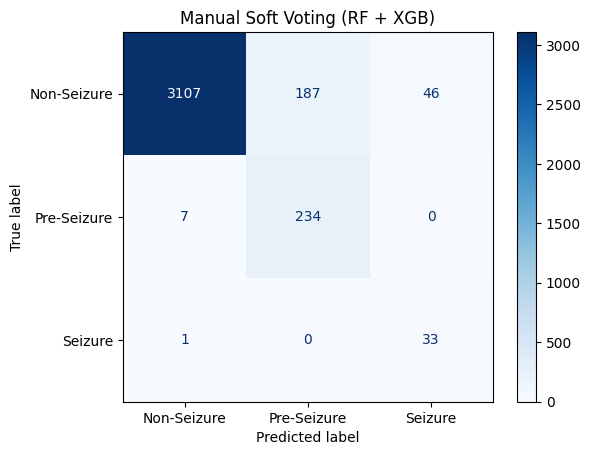

In [16]:
import joblib
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔁 Load models
rf_model = joblib.load("random_forest_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")

# 🧪 Use your preprocessed data (same used for RF/XGB training)
# X_all = ... (features), y_all = ... (labels)
# Example split:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=0.1, random_state=42)

# 🔮 Predict probabilities
proba_rf = rf_model.predict_proba(X_test)
proba_xgb = xgb_model.predict_proba(X_test)

# 📊 Average the probabilities (soft voting)
avg_proba = (proba_rf + proba_xgb) / 2
final_preds = np.argmax(avg_proba, axis=1)

# ✅ Evaluation
print("✅ Classification Report:")
print(classification_report(y_test, final_preds, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))
print(f"✅ Accuracy: {accuracy_score(y_test, final_preds) * 100:.2f}%")

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Pre-Seizure", "Seizure"])
disp.plot(cmap="Blues")
plt.title("Manual Soft Voting (RF + XGB)")
plt.show()


Bagging


✅ Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.84      0.89      3340
 Pre-Seizure       0.88      0.94      0.91      3340
     Seizure       0.96      1.00      0.98      3340

    accuracy                           0.93     10020
   macro avg       0.93      0.93      0.93     10020
weighted avg       0.93      0.93      0.93     10020

✅ Accuracy: 92.73%


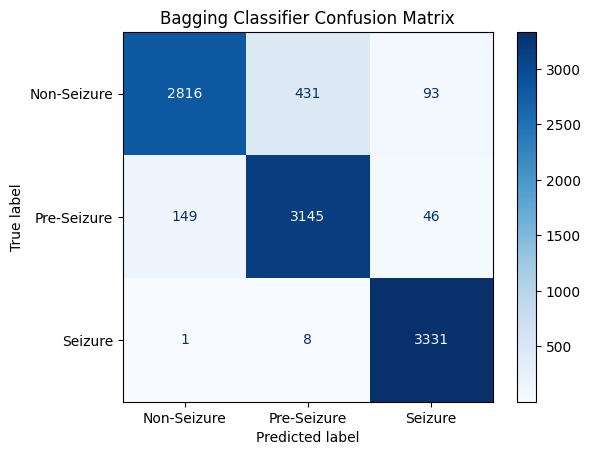


💾 Saved bagging model as bagging_model.pkl


In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 🧪 Use your preprocessed data
# Replace this with actual data
# X_all = np.load("X_all.npy")
# y_all = np.load("y_all.npy")

# Example only:
# X_all = np.random.rand(1000, 24)
# y_all = np.random.randint(0, 3, 1000)

# 1. Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_all, y_all)

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)

# 3. Define a base estimator (can be RandomForest, XGBoost, etc.)
base_estimator = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 4. Define the Bagging ensemble
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(
    estimator=base_estimator,       # ✅ use 'estimator' instead of 'base_estimator'
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)


# 5. Train the BaggingClassifier
bagging_model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = bagging_model.predict(X_test)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# 7. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Pre-Seizure", "Seizure"])
disp.plot(cmap="Blues")
plt.title("Bagging Classifier Confusion Matrix")
plt.show()

# 8. Save the model
joblib.dump(bagging_model, "bagging_model.pkl")
print("\n💾 Saved bagging model as bagging_model.pkl")


**Boosting**


✅ Classification Report:
              precision    recall  f1-score   support

 Non-Seizure       0.88      0.72      0.79      3340
 Pre-Seizure       0.79      0.84      0.82      3340
     Seizure       0.88      0.98      0.93      3340

    accuracy                           0.85     10020
   macro avg       0.85      0.85      0.84     10020
weighted avg       0.85      0.85      0.84     10020

✅ Accuracy: 84.67%


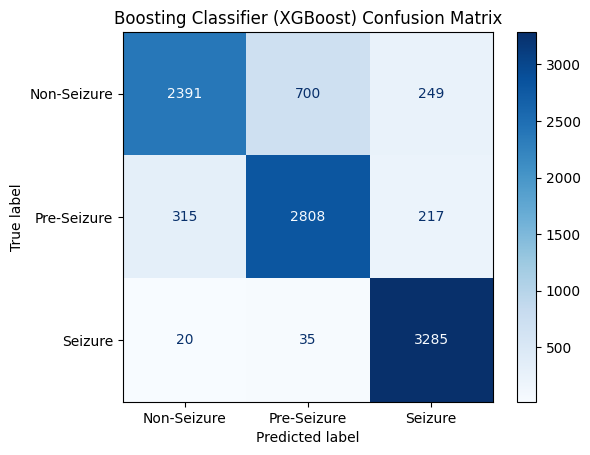


💾 Saved boosting model as boosting_model.pkl


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import joblib

# 🧪 Replace this with your actual feature and label arrays
# X_all = np.load("X_all.npy")
# y_all = np.load("y_all.npy")

# 1. Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_all, y_all)

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)

# 3. Define the Boosting model (XGBoost)
boosting_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# 4. Train the model
boosting_model.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = boosting_model.predict(X_test)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Seizure", "Pre-Seizure", "Seizure"])
disp.plot(cmap="Blues")
plt.title("Boosting Classifier (XGBoost) Confusion Matrix")
plt.show()

# 7. Save the model
joblib.dump(boosting_model, "boosting_model.pkl")
print("\n💾 Saved boosting model as boosting_model.pkl")


# 